# Visualization of the results of the chunking experiments

In [24]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

FIGURES_PATH = Path("figures/")

sns.set_theme(
    style="whitegrid",
    context="paper",
    font="DejaVu Serif",
    font_scale=1.3,
    palette="pastel",
)

DPI = 300
FIGSIZE_S = (8, 5)
FIGSIZE_L = (15, 5)

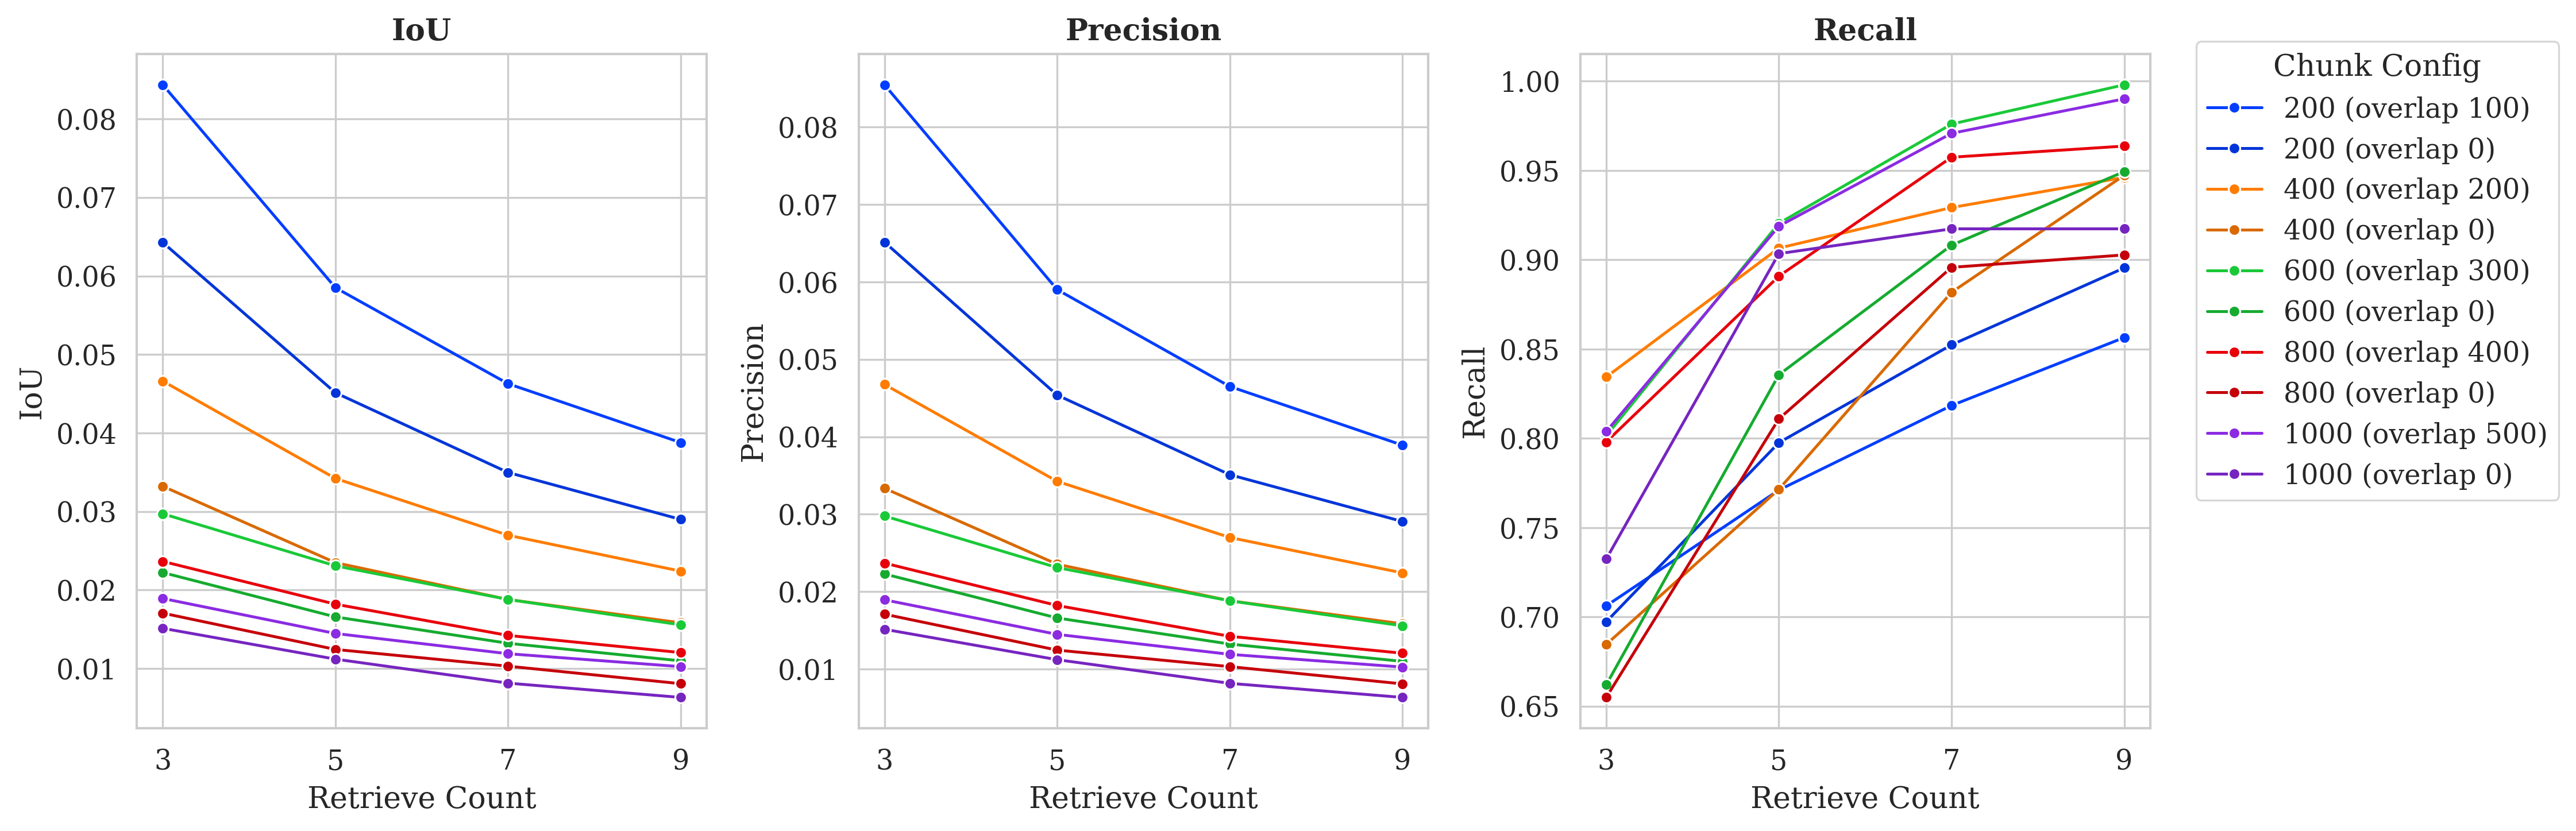

In [29]:
# Read the YAML data from file
with open("data/output.yaml", "r") as f:
    data = yaml.safe_load(f)

# Convert data into a DataFrame
rows = []
for d in data:
    row = {
        "chunk_size": d["chunk_size"],
        "chunk_overlap": d["chunk_overlap"],
        "retrieve_count": d["retrieve_count"],
        "iou": d["metrics"]["iou"],
        "precision": d["metrics"]["precision"],
        "recall": d["metrics"]["recall"],
    }
    row["config"] = f"{row['chunk_size']} (overlap {row['chunk_overlap']})"
    rows.append(row)

df = pd.DataFrame(rows)

# Same base color but different shades for same chunk sizes
unique_sizes = sorted(df["chunk_size"].unique())
base_colors = sns.color_palette("bright", n_colors=len(unique_sizes))
palette = {}
for i, size in enumerate(unique_sizes):
    size_configs = df[df["chunk_size"] == size]["config"].unique()
    # Create shades of the base color
    shades = [base_colors[i]] * len(size_configs)
    if len(size_configs) > 1:
        shades[1] = tuple(x * 0.85 for x in base_colors[i])  # slightly darker shade
    palette.update(dict(zip(size_configs, shades)))

fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_L, dpi=DPI, sharex=True)
metric_list = [("iou", "IoU"), ("precision", "Precision"), ("recall", "Recall")]

# Data for the x-ticka
retrieve_counts = sorted(df["retrieve_count"].unique())

for ax, (metric, title) in zip(axes, metric_list):
    sns.lineplot(
        data=df,
        x="retrieve_count",
        y=metric,
        hue="config",
        marker="o",
        ax=ax,
        palette=palette,
    )
    ax.set_title(title, fontweight='semibold')
    ax.set_xlabel("Retrieve Count", fontweight='medium')
    ax.set_ylabel(title, fontweight='medium')
    ax.set_xticks(retrieve_counts)  # explicit ticks
    ax.legend_.remove()

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Chunk Config", bbox_to_anchor=(0.85, 0.95), loc="upper left"
)
plt.tight_layout(rect=[0, 0, 0.85, 1])

figure_path = FIGURES_PATH / "metrics_comparison.png"
plt.savefig(str(figure_path), bbox_inches="tight", dpi=DPI)
plt.show()